Retomando el ejemplo de la clase pasada, construimos una red neuronal de una sola capa utilizando la base de datos de MNIST. Los creadores originales tienen una página en la que comparan los distintos métodos existentes y sus respectivos errores. [[link]](http://yann.lecun.com/exdb/mnist/)

En esta sesión retomaremos esta base de datos y trabajaremos con distintos algoritmos para la clasificación. Empezaremos con 2 algoritmos ajenos a la familia de redes neuronales: SVMs y KNN.

# KNN

El algoritmo de K-Nearest Neighbors (KNN) consiste en:

1. Ingresar los datos de entrenamiento `X_train`, con sus etiquetas correspondientes) `y_train`.
2. Dado un valor de k (los k vecinos más cercanos) y un punto en el conjunto de entrenamiento `x_0`, la etiqueta `y_0` que asigna el algoritmo es la más común entre los k vecinos más cercanos. 

**Nota:** Existen varias formas para romper los "empates" como seleccionar un valor al azar entre los candidatos, o ponderar los votos según la distancia de los k vecinos más cercanos. Sci-kit learn utiliza el órden de los datos de entrenamiento para romper empates cuando no se ponderan los candidatos por la distancia.

<img src="https://cdn-images-1.medium.com/max/800/0*Sk18h9op6uK9EpT8.">

In [1]:
from sklearn import datasets
import numpy as np
skl_mnist=datasets.load_digits()

In [2]:
from sklearn.model_selection import train_test_split

#separamos el conjunto de prueba con 25% de los datos

(restData, testData, restLabels, testLabels) = train_test_split(np.array(skl_mnist.data),
skl_mnist.target, test_size=0.25, random_state=42)

# del conjunto restante, usaremos 10% para validación

(trainData, valData, trainLabels, valLabels) = train_test_split(restData, restLabels,
test_size=0.1, random_state=84)

In [3]:
trainData.shape, valData.shape, testData.shape

((1212, 64), (135, 64), (450, 64))

In [4]:
trainData[0] #matrices de 8x8 aplanadas en vectores de 64 entradas

array([ 0.,  0.,  6., 16., 16., 11.,  0.,  0.,  0.,  1., 16.,  8.,  8.,
       16.,  6.,  0.,  0.,  0.,  8., 16., 14., 16., 11.,  0.,  0.,  0.,
        1.,  4.,  3., 10.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  7.,
        0.,  0.,  0.,  0.,  0.,  1., 14.,  1.,  0.,  0.,  0.,  4.,  7.,
       11.,  9.,  0.,  0.,  0.,  0.,  9., 16., 10.,  1.,  0.,  0.])

9


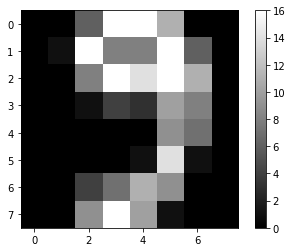

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print(trainLabels[0])
plt.imshow(trainData[0].reshape((8,8)), cmap='gray', vmin=0, vmax=16)
plt.colorbar()
plt.grid(False)
plt.show()

**Nota:** Los algoritmos de scikit learn no están diseñados para implementarse en GPU, por lo que se utiliza una base de datos de menor tamaño para entrenar los algoritmos.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

kVals = range(1, 30, 2)
accuracies = []

# iterar sobre los valores del híper-parámetro k pasos de 2

for k in range(1, 30, 2):
    
    model = KNeighborsClassifier(n_neighbors=k) #entrenamiento
    model.fit(trainData, trainLabels)
    
    score = model.score(valData, valLabels) #validación
    print("k=%d, accuracy=%.3f%%" % (k, score * 100))
    accuracies.append(score)
          
# encontrar el valor de k con mayor precisión

i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.3f%% on validation data" % (kVals[i],accuracies[i] * 100))

k=1, accuracy=99.259%
k=3, accuracy=99.259%
k=5, accuracy=99.259%
k=7, accuracy=99.259%
k=9, accuracy=99.259%
k=11, accuracy=99.259%
k=13, accuracy=99.259%
k=15, accuracy=99.259%
k=17, accuracy=98.519%
k=19, accuracy=98.519%
k=21, accuracy=97.778%
k=23, accuracy=97.037%
k=25, accuracy=97.778%
k=27, accuracy=97.037%
k=29, accuracy=97.037%
k=1 achieved highest accuracy of 99.259% on validation data


In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#re-entrenar el modelo con el valor óptimo de k hallado con los datos de validación
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(trainData, trainLabels)
predictions = model.predict(testData)

print("Métricas con Datos de Prueba")
print(classification_report(testLabels, predictions))

print ("Matriz de Confusión")
print(confusion_matrix(testLabels,predictions))


Métricas con Datos de Prueba
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        38
           3       0.98      0.98      0.98        46
           4       0.98      0.98      0.98        55
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        45
           7       1.00      0.98      0.99        41
           8       0.97      0.95      0.96        38
           9       0.96      0.94      0.95        48

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Matriz de Confusión
[[43  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  1  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  

# SVMs

In [9]:
svm_grid = {'C':[0.001, 0.1, 100, 10e5], 'gamma':[10,1,0.1,0.01],'kernel':['rbf','poly','sigmoid']}

svm_grid['C']

[0.001, 0.1, 100, 1000000.0]

In [10]:
from sklearn.svm import SVC

svm_grid = {'C':[0.001, 0.1, 100, 10e5], 'gamma':[10,1,0.1,0.01],'kernel':['rbf','poly','sigmoid']}


# iterar sobre los valores de los híper-parámetros

accuracies = []

for c in svm_grid['C']:
    for g in svm_grid['gamma']:
        for k in svm_grid['kernel']:
            
            model=SVC(kernel=k,gamma=g,C=c) 
            model.fit(trainData, trainLabels) #entrenamiento
    
            score = model.score(valData, valLabels) #validación
            print("C=%d,gamma=%d,kernel=%s, accuracy=%.3f%%" % (c,g,k, score * 100))
            accuracies.append([c,g,k,score])

C=0,gamma=10,kernel=rbf, accuracy=9.630%
C=0,gamma=10,kernel=poly, accuracy=99.259%
C=0,gamma=10,kernel=sigmoid, accuracy=9.630%
C=0,gamma=1,kernel=rbf, accuracy=9.630%
C=0,gamma=1,kernel=poly, accuracy=99.259%
C=0,gamma=1,kernel=sigmoid, accuracy=9.630%
C=0,gamma=0,kernel=rbf, accuracy=9.630%
C=0,gamma=0,kernel=poly, accuracy=99.259%
C=0,gamma=0,kernel=sigmoid, accuracy=9.630%
C=0,gamma=0,kernel=rbf, accuracy=9.630%
C=0,gamma=0,kernel=poly, accuracy=99.259%
C=0,gamma=0,kernel=sigmoid, accuracy=9.630%
C=0,gamma=10,kernel=rbf, accuracy=9.630%
C=0,gamma=10,kernel=poly, accuracy=99.259%
C=0,gamma=10,kernel=sigmoid, accuracy=9.630%
C=0,gamma=1,kernel=rbf, accuracy=9.630%
C=0,gamma=1,kernel=poly, accuracy=99.259%
C=0,gamma=1,kernel=sigmoid, accuracy=9.630%
C=0,gamma=0,kernel=rbf, accuracy=9.630%
C=0,gamma=0,kernel=poly, accuracy=99.259%
C=0,gamma=0,kernel=sigmoid, accuracy=9.630%
C=0,gamma=0,kernel=rbf, accuracy=9.630%
C=0,gamma=0,kernel=poly, accuracy=99.259%
C=0,gamma=0,kernel=sigmoid, ac

In [11]:
import pandas as pd

#seleccionar los parámetros óptimos

resultados_svm=pd.DataFrame(accuracies)
resultados_svm.columns=['C','Gamma','Kernel','Accuracy']
resultados_svm.sort_values(by='Accuracy',ascending=False).head() 

,C,Gamma,Kernel,Accuracy
28,100.0,1.00,poly,0.992593
25,100.0,10.00,poly,0.992593
22,0.1,0.01,poly,0.992593
16,0.1,1.00,poly,0.992593
37,1000000.0,10.00,poly,0.992593


In [12]:
#re-entrenar el modelo con el valor óptimo de los híper-parámetros

model = SVC(C=100,gamma=1,kernel='poly')
model.fit(trainData, trainLabels)

predictions = model.predict(testData)

print("Métricas con Datos de Prueba")
print(classification_report(testLabels, predictions))

print ("Matriz de Confusión")
print(confusion_matrix(testLabels,predictions))

Métricas con Datos de Prueba
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        38
           3       0.98      0.96      0.97        46
           4       1.00      1.00      1.00        55
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        45
           7       0.98      0.98      0.98        41
           8       0.97      1.00      0.99        38
           9       0.98      0.96      0.97        48

   micro avg       0.99      0.99      0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Matriz de Confusión
[[43  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 44  0  1  0  0  1  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  

# Feed-Forward Neural Network

Ahora pasaremos a la implementación con redes neuronales en tensorflow. Recordamos que el algoritmo de entrenamiento de una red neuronal consiste en:

1. Inicializar los pesos $\mathcal{W}$ y sesgos $\mathbf{b}$ de la red neuronal
2. Realizar predicciones $y_{train}$ con los datos de entrenamiento $X_{train}$.
3. Calcular el error en las predicciones. Típicamente se utiliza la función:

$$\mathcal{L}(\mathbf{X},\mathbf{y}_{actual},\mathcal{W},\mathcal{b})=\frac{1}{2}\sum_{i=1}^N||\mathbf{y}_{i\ pred}(\mathbf{x}_i,\mathcal{W},\mathcal{b})-\mathbf{y}_{i\ actual}||^2.$$

4. Calcular el gradiente de la función de error con respecto a los sesgos y pesos mediante Backpropagation.
5. Ajustar los valores de los sesgos y pesos según el algoritmo de descenso (SGD, Momento, Adagrad, etc.)
6. Repetir los pasos 2 a 5 hasta obtener una precisión deseada.

Este ciclo de entrenamiento se ilustra a continuación:

<img src="images/backprop_cycle.png" width=800>

Dado que la información fluye hacia "adelande" en la red neuronal (en la gráfica de operaciones según tensorflow), a este tipo de redes se les conoce como **redes feedforward** (redes pre-alimentadas en español). Esto es en contraste con las **redes convolucionales** que forman cíclos en la red. 

**Obs:** Esto no debe confundirse con el algoritmo de Backpropagation, que únicamente se refiere a la forma de calcular el gradiente, no a la estructura de la red.

Como vimos en la sesión 9, estas redes son una generalización del modelo del Perceptrón, incorporando más capas y distintas funciones de activación. Por esto, a estas redes también se les llaman **Perceptrones Multicapas** (MLP en inglés).

Importaremos lo datos incluídos en la librería, los cuales son imagenes de 28x28, aplanadas en vectores de 784 entradas.

In [13]:
import tensorflow as tf
import numpy as np

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [15]:
X_train, Y_train, X_test, Y_test=mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [16]:
X_val,Y_val=mnist.validation.images,mnist.validation.labels

In [18]:
X_train.shape, Y_train.shape, X_test.shape,  Y_test.shape

((55000, 784), (55000, 10), (10000, 784), (10000, 10))

In [17]:
X_val.shape,Y_val.shape

((5000, 784), (5000, 10))

Exploremos los datos:

In [18]:
print(X_train[0].shape) #784=28*28

(784,)


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


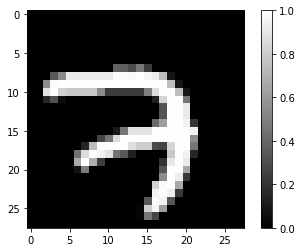

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


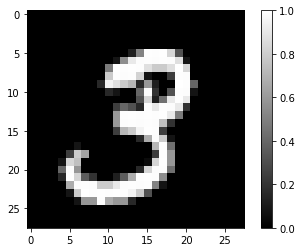

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


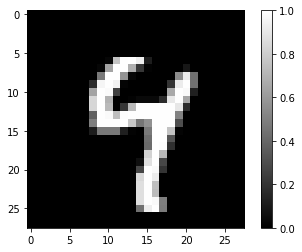

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


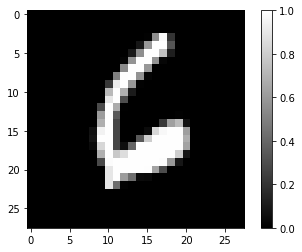

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


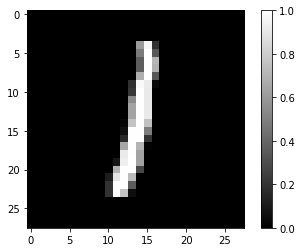

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


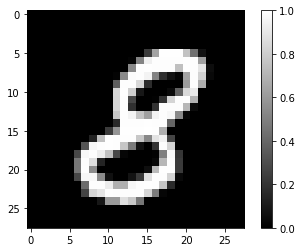

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


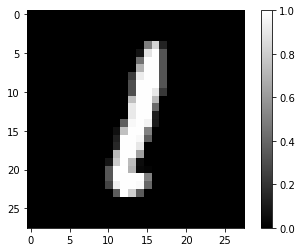

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


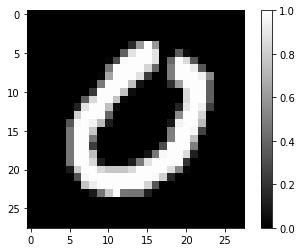

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


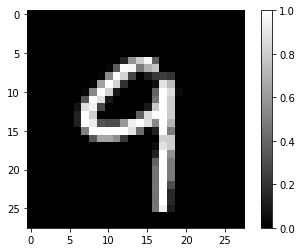

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


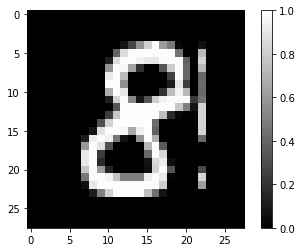

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,10):
    print(Y_train[i])
    plt.imshow(X_train[i].reshape((28,28)), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.grid(False)
    plt.show()

Definimos la gráfica de operaciones. Incluye las operaciones de la red neuronal, así como operaciones para guardar los valores históricos de cada variable u operación.

In [20]:
g_train=tf.Graph()
with g_train.as_default():

    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, [None, 784],name='x_data')
        tf.summary.image('input_image', tf.reshape(X, (-1, 28, 28, 1)), max_outputs=5)
        Ydata = tf.placeholder(tf.float32, [None, 10],name='y_data') 
    
    with tf.name_scope("fitting_variables"):
        with tf.name_scope("weights"):
            #initer = tf.truncated_normal_initializer(stddev=0.01)
            W = tf.Variable(tf.zeros([784,10]),name='w')
            tf.summary.histogram("wieghts",W)
        with tf.name_scope("bias"):
            b = tf.Variable(tf.ones([10]),name='b')
            tf.summary.histogram("biases",b)
    
    with tf.name_scope("operations"):
        prod=tf.matmul(X,W,name="mult") #transponemos W^t X^t ==> X W. 
        # cada dato es una fila en X, la matriz W la renombramos como W^t para tener W al final
        sumation=prod+b #sumar b verticalmente con broadcasting
        
    with tf.name_scope("outputs"):
        Ymod = tf.nn.softmax(sumation,name="Ymod") 
    
    with tf.name_scope("evaluation"):
        with tf.name_scope("cross_entropy"):
            cross_entropy = tf.reduce_mean(-tf.reduce_sum(Ydata * tf.log(Ymod+1e-8), reduction_indices=[1])) 
            tf.summary.scalar("cross_entropy",cross_entropy)
        
        with tf.name_scope("correct_prediction"):
            correct_prediction = tf.equal(tf.argmax(Ymod,axis=1), tf.argmax(Ydata,axis=1)) 
            #tf.summary.tensor_summary("correct_prediction",correct_prediction)
        
        with tf.name_scope("accuracy"):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 
            tf.summary.scalar("accuracy",accuracy)
        
    with tf.name_scope("optimizer"):
        train_step = tf.train.AdamOptimizer(learning_rate=0.01, name='Adam-op').minimize(cross_entropy)
        
    init=tf.global_variables_initializer()
    merged=tf.summary.merge_all()
    
    """
    # Inicializar la variable del embedding con la forma del tensor deseado
    tensor_shape = (X_test.shape[0] , Ymod.get_shape()[1].value) # [test_set , ymod] = [10000 , 10]
    embedding_var = tf.Variable(tf.zeros(tensor_shape), name='ymod_embedding')
    # asignar el tensor Ymod a la variable del embbedding
    embedding_assign = embedding_var.assign(Ymod)
    """

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Corremos el algoritmo, calculando la precisión al final de cada época sobre los conjuntos de entrenamiento, validación y prueba.

A sí mismo, calculamos la pérdida y el error en cada iteeración para la muestra (batch) de entrenamiento.

In [21]:
import time, os

batch_size=100
no_of_epochs=20

img_h = img_w = 28

iteration_loss=[]
iteration_acc=[]

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

with tf.Session(graph=g_train) as sess1:
    
    summaries_dir="logs/tensorflow"
    time_stamp=time.strftime("%H:%M:%S") #string con formato hora:minuto:segundo
    summaries_dir=summaries_dir+time_stamp
    
    #directorios para guardar logs de summary, se utilizan en tensorboard
    train_writer = tf.summary.FileWriter(summaries_dir+'/train',sess1.graph)
    valid_writer = tf.summary.FileWriter(summaries_dir + '/valid',sess1.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test',sess1.graph)

    init.run()
    
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()
    
    #calculo inicial de accuracy, perdida,etc.
    summary,loss=sess1.run([merged,cross_entropy],feed_dict={X: X_train,Ydata: Y_train},
                            options=run_options,run_metadata=run_metadata) #adds metadada to summary 
    train_writer.add_summary(summary, 0)
    train_writer.add_run_metadata(run_metadata, 'loss_epoch%d' % 0)
    #print("Epoch:=",0,"; \t Epoch Loss:=",loss)
    
    summary,t_acc=sess1.run([merged,accuracy], feed_dict={X: X_train, Ydata: Y_train},
                             options=run_options,run_metadata=run_metadata) 
    train_writer.add_summary(summary, 0)
    train_writer.add_run_metadata(run_metadata, 'train_epoch%d' % 0)
    #print("Training Accuracy is", t_acc*100,"%")
    
    summary,v_acc=sess1.run([merged,accuracy], feed_dict={X: X_val,Ydata:Y_val},
                             options=run_options,run_metadata=run_metadata) #adds metadada to summary 
    valid_writer.add_summary(summary,0)
    valid_writer.add_run_metadata(run_metadata, 'valid_epoch%d' % 0)
    #print("Validation Accuracy is", v_acc*100,"%")
    
    summary,f_acc=sess1.run([merged,accuracy], feed_dict={X: X_test,Ydata:Y_test},
                             options=run_options,run_metadata=run_metadata) #adds metadada to summary 
    test_writer.add_summary(summary,0)
    test_writer.add_run_metadata(run_metadata, 'test_epoch%d' % 0)
    #print("Test Accuracy is", f_acc*100,"%")
    
    sum_data=np.array([0,loss,t_acc,v_acc,f_acc]) #agregar los datos de la epoca 0 en una lista
    
    
    for epoch in range(no_of_epochs):
        epoch_loss=0
        
        for i in range(int(mnist.train.num_examples/batch_size)): #una epoca se divide según el tamaño del batch 
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
            train,loss,acc=sess1.run([train_step,cross_entropy,accuracy], feed_dict={X: batch_xs, Ydata: batch_ys},
                                     options=run_options,run_metadata=run_metadata)
            
            if i==0:
                train_writer.add_run_metadata(run_metadata, 'train_step%d' % (epoch))
            #calcular gradiente y pérdida sobre los datos del batch (se usan todas la variables de la gráfica)
            
            epoch_loss+=loss #calcula la pérdida por cada batch y la suma para tener la pérdida final en la época
            iteration_loss.append(loss)
            iteration_acc.append(acc)
        
        epoch_loss=epoch_loss/mnist.train.num_examples #pérdida/error promedio sobre toda la época 
        #print("Epoch:=",(epoch+1),"; \t Epoch Loss:=",epoch_loss)
        
        
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        
        summary,t_acc=sess1.run([merged,accuracy], feed_dict={X: X_train, Ydata: Y_train}, #calculates training accuracy 
                               options=run_options,run_metadata=run_metadata) #adds metadada to summary       
        train_writer.add_summary(summary, (epoch+1))
        train_writer.add_run_metadata(run_metadata, 'train_epoch%d' % (epoch+1))
        #print("Training Accuracy is", t_acc*100,"%")
        
        summary,v_acc=sess1.run([merged,accuracy], feed_dict={X: X_val,Ydata:Y_val},
                               options=run_options,run_metadata=run_metadata)
        valid_writer.add_summary(summary, (epoch+1))
        valid_writer.add_run_metadata(run_metadata, 'valid_epoch%d' % (epoch+1))
        #print("Validation Accuracy is", v_acc*100,"%")
        
        summary,f_acc=sess1.run([merged,accuracy], feed_dict={X: X_test,Ydata:Y_test},
                                options=run_options,run_metadata=run_metadata)
        test_writer.add_summary(summary, (epoch+1))
        test_writer.add_run_metadata(run_metadata, 'test_epoch%d' % (epoch+1))
        #print("Test Accuracy is", f_acc*100,"%")
        
        sum_data=np.vstack((sum_data,np.array([(epoch+1),epoch_loss,t_acc,v_acc,f_acc])))
        print("Finished Epoch",(epoch+1))
    
    """
    #La siguiente sección se utiliza para crear la proyección del embedding
    from tensorflow.contrib.tensorboard.plugins import projector

    # Crear un objeto de configuración, al cual le pasaremos los parámetros
    config = projector.ProjectorConfig()

    # Añadir la variable de embedding definida arriba
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    # Ligar el tensor del embedding al archivo de metadatos
    embedding.metadata_path = 'metadata.tsv'

    # Especificar ubicación y dimensiones del sprite
    embedding.sprite.image_path = 'sprite_images.png'
    embedding.sprite.single_image_dim.extend([img_w, img_h])

    # Escribir el proyector en un archivo projector_config.pbtxt en summaries_dir
    # tensorboard leerá esta ubicación al iniciarse/refrescarse
    embedding_writer = tf.summary.FileWriter(summaries_dir,sess1.graph)
    projector.visualize_embeddings(embedding_writer, config)

    # Ejecutar en la sesión el valor del embedding. Depende de Ymod, por lo que depdende de X
    x_test_fc1 = sess1.run(embedding_assign, feed_dict={X: X_test})

    # Guardar el tensor en un archivo ckpt en summaries_dir
    saver = tf.train.Saver()
    saver.save(sess1, os.path.join(summaries_dir, "model.ckpt"), no_of_epochs)


    # Cambiar los datos de vectores de vuelta a matrices (imagenes)
    x_test_images = np.reshape(np.array(X_test), (-1, img_w, img_h))
    # Cambiar las etiquetas de one-hot a numeros
    x_test_labels = np.argmax(Y_test, axis=1)
    
    #utilizar las funciones deifnidas abajo para crear los archivos sprite y metadata.
    write_sprite_image(os.path.join(summaries_dir, 'sprite_images.png'), x_test_images)
    write_metadata(os.path.join(summaries_dir, 'metadata.tsv'), x_test_labels)
    """

Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
Finished Epoch 10
Finished Epoch 11
Finished Epoch 12
Finished Epoch 13
Finished Epoch 14
Finished Epoch 15
Finished Epoch 16
Finished Epoch 17
Finished Epoch 18
Finished Epoch 19
Finished Epoch 20


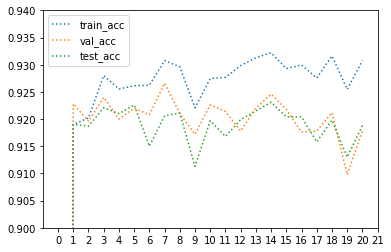

In [24]:
plt.ylim(0.9,0.94)
plt.xticks(range(0, 22))

#plt.plot(sum_data[:,0],sum_data[:,1],label="epoch_loss")
plt.plot(sum_data[:,0],sum_data[:,2],label="train_acc",ls=':')
plt.plot(sum_data[:,0],sum_data[:,3],label="val_acc",ls=':')
plt.plot(sum_data[:,0],sum_data[:,4],label="test_acc",ls=':')
plt.legend()
plt.show()

#la precisión con prueba y validación pueden quedarse por debajo de la de entrenamiento (overfitting) 
#parece que el valor ideal de épocas es 10-15

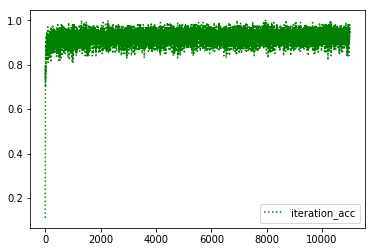

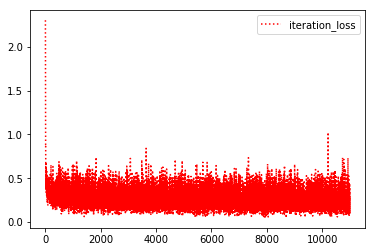

In [25]:
#plt.ylim(0.7,1)
plt.plot(iteration_acc,label="iteration_acc",ls=':',color='green')
plt.legend()
plt.show()

plt.plot(iteration_loss,label="iteration_loss",ls=':',color='red')
plt.legend()
plt.show()

In [31]:
#saving

tf.reset_default_graph()

W = tf.Variable([[1,2,3],[1,2,3]],dtype=tf.float32,name='s_weights')
b = tf.Variable([[1,2,3]],dtype=tf.float32,name='s_biases')
init=tf.global_variables_initializer()

saver= tf.train.Saver()

with tf.Session() as sess:
    sess.run(init) 
    save_path=saver.save(sess,"tf_models/my_nn_savefile.ckpt") #guarda todo el contenido actual de la sesión
    print("Save to",save_path)

Save to tf_models/my_nn_savefile.ckpt


In [32]:
#restoring

tf.reset_default_graph()

#se necesitan tener los mismos nombres y forma de los arreglos
#puede pensarse como otra forma de inicializar variables
W=tf.Variable(tf.zeros([2,3]),dtype=tf.float32,name='s_weights')
b=tf.Variable(tf.zeros([1,3]),dtype=tf.float32,name='s_biases')

saver=tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,"tf_models/my_nn_savefile.ckpt") 
    print("weights:",sess.run(W))
    print("biases:",sess.run(b))

INFO:tensorflow:Restoring parameters from tf_models/my_nn_savefile.ckpt
weights: [[1. 2. 3.]
 [1. 2. 3.]]
biases: [[1. 2. 3.]]


**Nota:** También podemos utilizar `saver` para añadir una operación que guarde únicamente una variable.

`saver = tf.train.Saver({"b": b})`

En este caso, tenemos que inicializar W, pues el objeto `saver` no lo hace.

# Tensorboard

Es una herramienta de visualización complementaria a Tensorflow. Utiliza los logs creados con `tf.summary` para crear visualizaciones de la gráfica y de las operaciones individuales, lo cual sirve para analizar los modelos creados.

Para iniciar Tensorboard, desde la terminal se introduce el comando `tensorboard --logdir=mi_directorio_de_logs`. En este caso, nosotros definimos `logdir=logs`.

### Embeddings: Reducción de Dimensiones para Visualización

Una función muy útil de tensorboard es la capacidad de crear visualizaciones en 3D de datos de un gran número de dimensiones. Esto se hace mediante objetos llamados `embeddings`. Para esto es necesario crear 2 archivos:

1. **metadata.tsv:** Una tabla que guarda el índice y etiqueta de cada dato.
2. **sprite_image.png:** Una imagen grande formada por un arreglo de todos los datos en forma de imagen.

A continuación deifnimos las funciones encargadas de hacerlo.

In [33]:
def write_sprite_image(filename, images):
    """
        Create a sprite image consisting of sample images
        :param filename: name of the file to save on disk
        :param shape: tensor of flattened images
    """

    # invertir las  imagenes de escala de grises (negativos)
    images = 1 - images

    # Calcular el no de gráficas
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    # generar el fondo del sprite
    sprite_image = np.ones((img_h * n_plots, img_w * n_plots))

    for i in range(n_plots):
        for j in range(n_plots):
            img_idx = i * n_plots + j
            if img_idx < images.shape[0]:
                img = images[img_idx]
                sprite_image[i * img_h:(i + 1) * img_h,
                j * img_w:(j + 1) * img_w] = img

    plt.imsave(filename, sprite_image, cmap='gray')
    print('Sprite image saved in {}'.format(filename))

def write_metadata(filename, labels):
    """
            Create a metadata file image consisting of sample indices and labels
            :param filename: name of the file to save on disk
            :param shape: tensor of labels
    """
    with open(filename, 'w') as f:
        f.write("Index\tLabel\n")
        for index, label in enumerate(labels):
            f.write("{}\t{}\n".format(index, label))

    print('Metadata file saved in {}'.format(filename))

Una vez hecho esto, volvemos a entrenar el modelo de arriba, sólo que ahora utilizaremos las líneas que estaban comentadas.

A sí mismo, los archivos **metadata.tsv** y **sprite_image.png**. Se pueden utilizar para crear otro tipo de visualizaciones. [[link1]](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd) [[link2]](http://scs.ryerson.ca/~aharley/vis/)

# La misma red con Keras

Comparemos el código que generamos con el que utiliza la librería Keras (API de alto nivel). Para evitar cualquier conflicto, reiniciamos el namespace del notebook.

In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import tensorflow as tf
mnist_keras = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist_keras.load_data()

In [28]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape #no separa el conjunto de validación

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [29]:
x_train[0] #las matrices ahora tienen valores enteros entre 0 y 225, i.e. no estan normalizadas

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

5


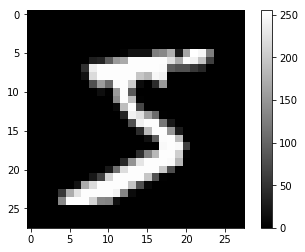

0


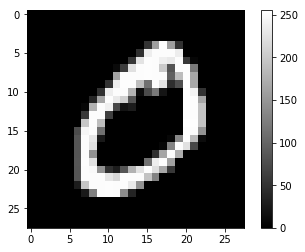

4


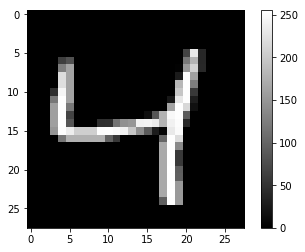

1


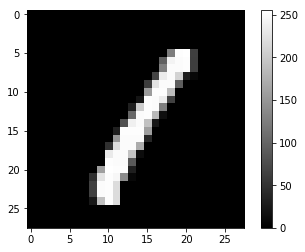

9


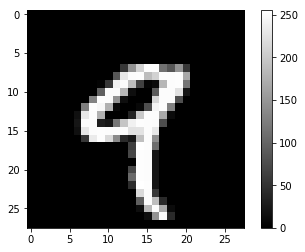

2


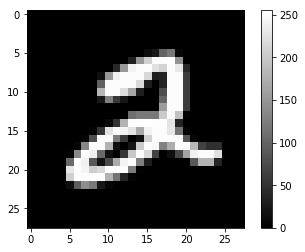

1


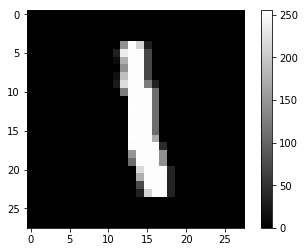

3


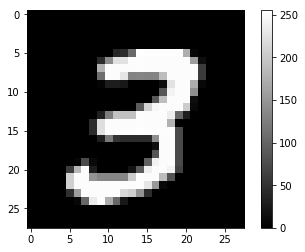

1


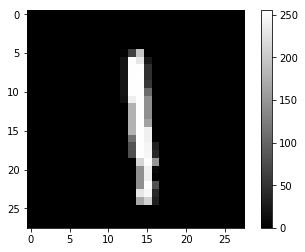

4


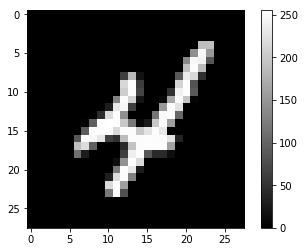

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,10):
    print(y_train[i]) #las entradas no estan en formato one-hot
    plt.imshow(x_train[i], cmap='gray', vmin=0, vmax=255) #los valores no estan normalizados
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [46]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [57]:
from tensorflow.keras.callbacks import TensorBoard
? TensorBoard

In [30]:
import time,os
from tensorflow.keras.callbacks import TensorBoard

summaries_dir="logs/Keras"
time_stamp=time.strftime("%H:%M:%S") #string con formato hora:minuto:segundo
summaries_dir=summaries_dir+time_stamp

tensorboard=TensorBoard(log_dir=summaries_dir)

#tf.reset_default_graph()
(x_train, y_train),(x_test, y_test) = mnist_keras.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 #normalizamos los datos (0,255)->(0,1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), #convierte la matriz de 28x28 en un vector de 784
  #tf.keras.layers.Dense(512, activation=tf.nn.relu),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #capa de 10 neuronas con todas las conexiones, activacion softmax
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Entrenamiento del Modelo")
model.fit(x_train, y_train, epochs=20,callbacks=[tensorboard])

print()
print("Evaluación con Datos de Prueba")
model.evaluate(x_test, y_test)

Entrenamiento del Modelo
Epoch 1/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.4732 - acc: 0.8756
Epoch 2/20
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3044 - acc: 0.9149
Epoch 3/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2834 - acc: 0.9203
Epoch 4/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2730 - acc: 0.9243
Epoch 5/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2662 - acc: 0.9259
Epoch 6/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2618 - acc: 0.9276
Epoch 7/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2579 - acc: 0.9281
Epoch 8/20
60000/60000 [==============================] - 2s 27us/sample - loss: 0.2553 - acc: 0.9289
Epoch 9/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2531 - acc: 0.9300
Epoch 10/20
60000/60000 [==============================] 

[0.2661818385243416, 0.9282]

# Regularización en Redes Neuronales

Anteriormente vimos que añadir penalizaciones a las funciones de error en OLS nos puede ayudar a "restringir" a que los parámetros tomen un rango de valores más aceptables, para así evitar sobre-ajustar los datos de entrenamiento. 

En general, [Goodfellow et. al. (Deep Learning 2016)](https://www.deeplearningbook.org/) definen la regularización como:

    Estrategias diseñadas explícitamente para reducir el error de prueba, posiblemente a costa del error de entrenamiento. 
    
A continuación veremos las más comunes para el entrenamiento de redes neuronales.

**1. Penalización de Parámetros:** Al igual que en el caso de de regresiones lineales, podemos añadir términos a la función de error (o pérdida) para evitar que los parámetros $\mathcal{W}$ sean demasiado grandes.

Recordemos que la función de error en las redes neuronales que mencionamos previamente es: 

$$\mathcal{L}(\mathbf{X},\mathbf{y}_{actual},\mathcal{W})=\frac{1}{2}\sum_{i=1}^N||\mathbf{y}_{i\ pred}(\mathbf{x}_i,\mathcal{W})-\mathbf{y}_{i\ actual}||^2.$$

Notemos que no denotamos $\mathbf{b}$ en la fórmula. Únicamente renombramos $\mathbf{w}_0=-\mathbf{b}$ y lo incluímos en $\mathcal{W}$, considerando $\mathbf{x}_0$ como un vector que tiene $-1$ en cada entrada.

Podemos añadir un término de error que depende de los parámetros $\lambda \Omega(\mathcal{W})$ de modo que la función de error a minimizar sea: 

$$\mathcal{L}(\mathbf{X},\mathbf{y}_{actual},\mathcal{W})=\frac{1}{2}\sum_{i=1}^N||\mathbf{y}_{i\ pred}(\mathbf{x}_i,\mathcal{W})-\mathbf{y}_{i\ actual}||^2 + \lambda \Omega(\mathcal{W}).$$

Lo más común es que $\Omega(\mathcal{W})$ sea una **p-norma** (también llamadas **Lp-normas**) ,i.e. 

$$\Omega(\mathcal{W})=\left( |w_1|^p + |w_2|^p + \dotsb + |w_n|^p \right) ^{1/p}.$$

**Obs:** p=1 corresponde a la regularización de valor absoluto utilizada en LASSO, mientras que p=2 corresponde a la regularización utilizada en Ridge. En estos casos, las propiedades de la regularización son los mismos que en el caso de regresión lineal. 

En $\mathbb{R}^2$, las fronteras de las vecindades de radio 1 se grafican a continuación: 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Vector-p-Norms_qtl1.svg/1024px-Vector-p-Norms_qtl1.svg.png" width=500>

**2. Bootstrapping y Validación-Cruzada:** Según la definición, estos métodos también puden considerarse como métodos de regularización, pues tienden a aumentar el error de entrenamiento, pero mejoran la generalización del modelo, i.e. el error de prueba al entrenar varios modelos con diferentes conjuntos de entrenamniento.

**3. Limitar el número de iteraciones (ealy stopping):** Al entrenar una red neuronal, nosotros especificamos el número de épocas en las que entrenaremos el algoritmo. Este número también es un híper-parámetro a optimizar en la construcción del modelo. 

Consideremos la siguiente gráfica:

<img src="images/early_stopping.png">

Se observa que el error (pérdida) de entrenamiento disminuye continuamente, pero el error calculado sobre el conjunto de validación alcanza un mínimo y comienza aumentar. Esto significa que se está sobre-ajustando los datos de entrenamiento.

Lo único que se requiere hacer es **fijarse en la época que da el mínimo error de validación y elegir los parámetros $\mathcal{W}$ en ese punto**.

**Obs:** La ventaja de este método es que no tenemos que hacer una búsqueda en una malla de parámetros, re-entrenando el algoritmo en cada caso. Únicamente necesitamos calcular el error de validación en cada época en el intervalo deseado.

Se puede pensar que este método restringe al algoritmo de entrenamiento dentro una vecindad de los parámetros iniciales, por lo que también se considera como un método de regularización.

**4. Dropout:** Este método consiste en seleccionar de manera aleatoria nodos en las capas de entrada o en las capas ocultas y eliminar (fijar en cero) sus salidas. Esto se hace en cada iteración de entrenamiento:

1. Se seleccionan los nodos a utilizar, cada uno seleccionado de manera independiente con cierta probabilidad $\theta$.
2. Se calcula la salida de la red $y_{predict}$.
3. Se calcula el gradiente con backpropagation en la red reducida.
4. Se modifican los parámetros según el gradiente obtenido.

<img src="https://cdn-images-1.medium.com/max/1400/1*skMXofkjeXtKzSr5lqIEmg.png">

Otra forma de entender esto es considerar un vector $\mathbf{\mu}_l(\theta)$ en la capa $l$ de la red neuronal, llamado la **máscara** de la capa $l$. Cada entrada del vector es 0 (eliminar la salida) o 1 (conservar la salida). La máscara se aplica a todas las salidas de cada neurona.

<img src="images/dropout_mask_horizontal.png" width=600>

La idea de implementar este método es evitar que la red neuronal dependa demasiado en conexiones o caminos específicos, lo cual tambien equivale a realizar regularización sobre los parámetros.

En tensorflow la máscara de cada capa se puede implementar mediante la función `tf.nn.dropout`. [[link]](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) Por lo tanto, el código para implementar Dropout en una capa sería:

In [ ]:
Y1 = tf.nn.relu(tf.matmul(X, W1) + B1)
Y1d = tf.nn.dropout(Y1, pkeep) 

#pkeep es la probabilidad de retener la salida
#rate = 1 - pkeep es la probabilidad de quitarla

# Convolutional Neural Networks

Ahora veremos un tipo especial de redes neuronales feedforward llamadas redes convolucionales. Hasta ahora, hemos visto únicamente redes de Perceptrón de Múltiples Capas (MLP) con operaciones como los que se muestran en la imagen:

<img src="images/mlp_model.png" width=700>

Como hemos visto, este tipo de modelos pueden ser muy útiles para reconocimiento de imágenes. Sin embargo, tienen ciertas limitaciones:

**1. Problemas de Dimensionalidad:** El número de parámetros que se requieren para una capa completamente conexa crece de manera cuadrática con el tamaño de la imagen. Por ejemplo, una imagen de 32 x 32 x 3 (3 canales RGB) equivale 3,072 entradas que se pasan a cada neurona de la primera capa. Una imagen de 200 x 200 x 3  equivale a 120,000 entradas por cada neurona!
Esto hace difícil crear algoritmos eficientes de clasificación con imágenes de alta definición. 

**2. Ignora la posición espacial de los datos:** Al aplanar una imagen monocromática (2D) a un vector (1D) se ignora el comportamiento local de los pixeles en la imagen, i.e. se trata igual a puntos muy cercanos o muy lejanos en la imagen.

<img src="http://testerstories.com/files/ai_and_ml/ml-mnist-2d-to-1d.png" width=500>

La situación es peor para imágenes de varios canales de color (3D):

<img src="https://necromuralist.github.io/neural_networks/posts/image-to-vector/image2vector_kiank.png">

Para atacar estos problemas, las redes redes convolucionales utilizan las siguientes operaciones:

### 1. **Convolución de Kernels, Filtros o Máscaras**

Consideremos dos funciones $f(t):A \subseteq \mathbb{R} \to \mathbb{R} ,g(t): B \subseteq \mathbb{R} \to \mathbb{R}$. Entonces, la **convolución** de estas funciones se define como:

$$s(t)=(f * g)(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau$$

Esto es una forma de calcular el "traslape" de ambas funciones haciento lo siguiente:

1. Expresar ambas funciones en términos de una variable dummy $\tau$
2. Reflejar $g$: $g(\tau) \to (-\tau)$
3. Transladar $g$ en $t$: $g(-\tau) \to (t-\tau)$.
4. Integrar sobre $A \cap B$. Si $A \cap B \subset \mathbb{R}$, se pueden extender las funciones de modo que sean cero en $(A \cap B) ^ \complement$

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" width=500>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif" width=500>

Usualmente, cuando trabajamos con información en la computadora esta se encuentra discretizada, como con vectores , por lo que la expresión para calcular la convolución será:

$$s(t)=(f * g)(t) = \sum_{i=-\infty}^\infty f(i) g(t - i).$$

Si el dominio es finito, i.e. los vectores tienen un número finito de entradas, entonces se tiene que:

$$s(t)=(f * g)(t) = \sum_{i \in I} f(i) g(t - i),$$

con $I=\{i_0, i_0+1,...,i_0+N\}$. Típicamente $i_0=0$

Finalmente, si $f$ y $g$ son funciones en 2D (matrices), entonces tenemos que:

$$s(t,u)=(f * g)(t,u) = \sum_{i = 0}^N \sum_{j = 0}^M f(i,j) g(t - i, u - j).$$

**Nota:** Existe una operación similar llamada correlación-cruzada (cross-correlation) que no refleja $g$:

$$r(t)=(f \star g)(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t + \tau) \, d\tau$$

En términos de matrices 2D se tiene que: 

$$r(t,u)=(f \star g)(t,u) = \sum_{i = 0}^N \sum_{j = 0}^M f(i,j) g(t + i, u + j).$$

En Deep Learning, ambas operaciones se denominan convoluciones. Lo típico es que las paqueterías de software implementen correlación-cruzada, pero lo llamen convolución.

En procesamiento de imágenes, las imágenes monocromáticas se representan por matrices (2D), mientras que las imágenes a color con varios canales se representan como tensores de rango 3 (3D). En este caso, una de las funciones será la imagen, la otra función será el **filtro o kernel**, el cual se mueve sobre la imagen (cambiar t,u) para obtener diferentes valores de la convolución.

<img src="images/convolution_diagram.png" width=500>

Comúnmente, el kernel es más pequeño que la imágen, por lo que cada salida sólo filtra una porción de la imágen. Notemos que, si el kernel no es de 1x1, no puede operar en las orillas de la imagen. En ese caso, la salida será más pequeña que la imagen original.

<img src="https://mlnotebook.github.io/img/CNN/convSobel.gif" width=400>

Para solucionar esto, se puede extender la matriz de la imagen con un borde o **padding** de ceros.

<img src="https://mlnotebook.github.io/img/CNN/convZeros.png" width=400>

A sí mismo, se puede ajustar el número de pixeles que se desplaza el kernel en cada dirección (en la visualización de arriba se mueve 1 en dirección horizontal y 1 en dirección vertical). A este parámetro de desplazamiento se le llama **stride**.

Este método permite procesar imágenes de distinta manera según el filtro utilizado. [[link1]](https://en.wikipedia.org/wiki/Kernel_(image_processing)) [[link2]](https://mlnotebook.github.io/post/CNN1/)

La forma en la que se integran las convoluciones a Deep Learning es **dejar que los valores del kernel sean pesos que se ajustan automáticamente en la red neuronal**. Por lo tanto, cada salida se puede expresar como una función de los pesos del kernel $\mathbf{W}_i$ y una porción de la imagen $\mathbf{X}_i$: 

$$y_i = \mathbf{W}_i \star \mathbf{X}_i$$

A sí mismo, a la salida se le puede sumar un sesgo $b_i$ y usar una función de activación $H$ de modo que:

$$y_i =H(\mathbf{W}_i \star \mathbf{X}_i + b_i).$$

Por esta razón, cada salida se puede interpretar como una neurona y comúnmente se les llama **neuronas de convolución**. A la porción de la imagen que se introduce a la neurona se llama su **campo de recepción**.

Finalmente, se pueden aplicar distintos filtros a una imagen. Cada una de las salidas de los distintos filtros, se puede considerar como un **canal** de una nueva imagen. Estos canales se apilan uno sobre otro para crear una imagen compuesta de distintos canales.

<img src="images/multi_filter_conv.gif" width=600>



### 2. **Pooling**

Pooling es una ténica de reducción de muestreo que utiliza operaciones no-lineales para reducir el tamaño de cada canal de la imagen. Esto lo hace creando una partición de la imagen en subregiones rectangulares $X_i$ y aplicando una función a todas las entradas de la matriz (2D): **máximo**, promedio, norma L2, etc.

<img src="https://mlnotebook.github.io/img/CNN/poolfig.gif">

Al igual que con la convolución, estas capas son diferenciables y requieren que se le especifique el **tamaño del filtro** y el movimiento o **stride**.

Estas operaciones también pueden combinarse con capas de Perceptrones Multi-Capas. En general, se llama red convolucional a cualquier red neuronal que utilice convoluciones en vez del producto matricial en cualuquier punto de la red. La siguiente imagen muestra la arquitectura típica de una red convolucional utilizada en la vida real (AlexNet). 

<img src="https://cdn-images-1.medium.com/max/1200/1*wzflNwJw9QkjWWvTosXhNw.png" width=700>

Las operaciones de convolución y pooling tienen las siguientes características:

1. **Arreglos 3D de Neuronas:** Las capas de convolución en una red convolucional, al igual que las imágenes, pueden formar estructuras 3-D (también 2-D o 1-D), comparados con las estructuras 1D de las redes feed-forward estándar (MLPs).

2. **Conectividad Local:** Inspirados el funcionamiento de la corteza visual del cerebro, utilizan "filtros" que operan de manera local en cada imagen en el campo de recepción. 

3. **Pesos Compartidos y Equivarianza:** Cada filtro se aplica, por secciones, a toda la imagen. Con esto, las características se pueden detectar con los mismos pesos sin importar su lugar en la imagen. Esta propiedad se preserva ante translaciones de elementos en la imagen, por lo que se llama **Equivarianza de Translación**. Estas operaciones NO son equivariantes ante rotaciones o escalamiento de las imágenes.  

4. **Down Sampling:** Los filtros (convolución y pooling) permiten reducir el tamaño de la imagen, obteniendo muestras de menor tamaño de la imagen.

3. **Extracción de Características (Feature Extraction):** Agrupar varios filtros permite detectar o extraer de manera no-lineal características de la imagen útiles para su clasificación.

<img src="https://cdn-images-1.medium.com/max/800/1*yZQjaMKHjm1HzDF4t4juzg.png" width=500>

Esto es una interpretación general del funcionamiento de este tipo de redes. En algunos casos, puede ser que las características extraídas, no se comporten como nosotros deseamos:

<img src="images/confusing_a_cnn.png">

Este tipo de redes se usa principalmente para procesar imágenes, pero puede usarse en general con cualquier base de datos que tenga una estructura de malla.

<img src="images/cnn_data_types.png" width=500>

**Nota:** Añadir canales distintos de un tipo de dato puede pensarse como agregar una dimensión al arreglo de datos (tenor). También, al considerar varias muestras de una base de datos (i.e. mini-batch SGD), estas pueden representarse como una dimensión adicional. 

# Implementación en Tensorflow

In [66]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
import tensorflow as tf
import numpy as np

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [26]:
X_train, Y_train, X_test, Y_test=mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
X_val,Y_val=mnist.validation.images,mnist.validation.labels

In [27]:
X_train.shape #imagenes de 28x28

(55000, 784)

Para tener un código más limpio, definiremos funciones para crear tensores que utilizaremos varias veces.

In [28]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # ksize [1, x_size, y_size, 1] (kernel size)
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

Definimos la gráfica de operaciones: 2 capas de convolución y 2 capas completamente conectadas.

In [33]:
g_cnn=tf.Graph()
with g_cnn.as_default():
    # definir placeholders para las entradas de la red 
    X = tf.placeholder(tf.float32, [None, 784])   # 28x28
    Ydata = tf.placeholder(tf.float32, [None, 10])
    keep_prob = tf.placeholder(tf.float32)
    x_image = tf.reshape(X, [-1, 28, 28, 1])  # regresar de vector a matriz
    # print(x_image.shape)  # [n_samples, 28,28,1]
    
    ## convolution layer 1##
    W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, 1 capa/canal de entrada, 32 canales de salida
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
    h_pool1 = max_pool_2x2(h_conv1)                          # output size 14x14x32
    
    ## convolution layer 2##
    W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 14x14x64
    h_pool2 = max_pool_2x2(h_conv2)                          # output size 7x7x64
    
    ## fullyconnected layer 1##
    W_fc1 = weight_variable([7*7*64, 392])
    b_fc1 = bias_variable([392])
    # [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, rate=1.0-keep_prob)
    
    ## fullyconnected layer 2##
    W_fc2 = weight_variable([392, 10])
    b_fc2 = bias_variable([10])
    Ymod = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    
    # función de error y algoritmo para minimizarla
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(Ydata * tf.log(Ymod),reduction_indices=[1])) 
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(Ymod,1), tf.argmax(Ydata,1)) #compara horizontalmente,i.e. sobre cada vector one-hot
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #porcentaje de predicciones correctas

Entrenamos la red neuronal con 15 épocas y dropout con 0.3 de probabilidad. Incluimos mediciones de tiempo y barra de progreso en entrenamiento y prueba.

In [36]:
from ipywidgets import FloatProgress
from IPython.display import display
import time

start_time = time.time()

no_of_epochs=3
keep_probability=0.7
batch_size=100

with tf.Session(graph=g_cnn) as sess:
    tf.global_variables_initializer().run()
    saver= tf.train.Saver()
    
    #entrenamiento
    for epoch in range(no_of_epochs):
        
        epoch_loss=0.0
        t_acc=0.0
        
        # barra de progreso que se visualiza durante la ejecución
        f = FloatProgress(min=0, max=mnist.train.num_examples,description='Epoch %d'%(epoch+1))
        display(f) 
        
        for i in range(int(mnist.train.num_examples/batch_size)): #una epoca se divide según el tamaño del batch 
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
            train,loss=sess.run([train_step,cross_entropy], feed_dict={X: batch_xs, Ydata: batch_ys,
                                                                       keep_prob: keep_probability})
            acc=sess.run(accuracy, feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: 1.0})
            epoch_loss+=(loss*batch_size) 
            t_acc+=(acc*batch_size)
            f.value += batch_size #actualizar barra de progreso
            
        t_acc=t_acc/mnist.train.num_examples
        epoch_loss=epoch_loss/mnist.train.num_examples #pérdida/error promedio en la época
        f.close() #cerrar barra de progreso
    
        print("Finished Epoch",epoch+1,"Epoch Loss",epoch_loss,"Training Acc",t_acc*100,"%") 
        
    print("Finished Training in",(time.time() - start_time)/60, "minutes")
    save_path=saver.save(sess,"saved_variables/cnn_mnist.ckpt")
    
    #prueba
    start_time = time.time()
    test_acc=0.0
    num_of_samples=0.0
    
    #barra de progreso de prueba
    f = FloatProgress(min=0, max=mnist.test.num_examples,description='Testing')
    display(f)
    
    for i in range(int(mnist.test.num_examples/batch_size)): #una epoca se divide según el tamaño del batch 
        batch_xs, batch_ys = mnist.test.next_batch(batch_size) 
        acc=sess.run(accuracy, feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: 1.0})
        test_acc+=(acc*batch_size)
        #num_of_samples+=batch_size
        f.value += batch_size #actualizar barra de progreso
    
    test_acc=test_acc/mnist.test.num_examples
    f.close() #cerrar barra de progreso
    print("Finished Testing in",time.time() - start_time, "seconds")
    print("Test Accuracy",test_acc*100,"%")

FloatProgress(value=0.0, description='Epoch 1', max=55000.0)

Finished Epoch 1 Epoch Loss 0.6269385235553439 Training Acc 87.13090912997723 %


FloatProgress(value=0.0, description='Epoch 2', max=55000.0)

Finished Epoch 2 Epoch Loss 0.17532761997797272 Training Acc 96.24545502662659 %


FloatProgress(value=0.0, description='Epoch 3', max=55000.0)

Finished Epoch 3 Epoch Loss 0.11882968978109684 Training Acc 97.5600008314306 %
Finished Training in 3.227182654539744 minutes


FloatProgress(value=0.0, description='Testing', max=10000.0)

Finished Testing in 2.878779411315918 seconds
Test Accuracy 97.90000116825104 %


# Implementación en Keras

In [108]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [111]:
import tensorflow as tf

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout

mnist_keras = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist_keras.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 #normalizamos los datos (0,255)->(0,1)

x_train = x_train.reshape(60000,28,28,1) #(60000,28,28)-->(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1) #(10000,28,28)-->(10000,28,28,1)

tf.keras.backend.clear_session() #asegurarnos de que no interfiera con sesiones previas


#crear el modelo
model = Sequential()

#añadir capas
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu',input_shape=(14,14,32)))
model.add(Flatten())
model.add(Dense(392, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation='softmax'))


#compilar el modelo (definir métodos de entrenamiento y evaluación)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#sparse_categorical_crossentropy convierte las etiquetas a vectores one-hot


#entrenar el modelo
print("Entrenamiento del Modelo")
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

print()
print("Evaluación con Datos de Prueba")
model.evaluate(x_test, y_test)

Entrenamiento del Modelo
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 246s 4ms/sample - loss: 0.1013 - acc: 0.9694 - val_loss: 0.0511 - val_acc: 0.9835
Epoch 2/3
60000/60000 [==============================] - 247s 4ms/sample - loss: 0.0395 - acc: 0.9879 - val_loss: 0.0355 - val_acc: 0.9890
Epoch 3/3
60000/60000 [==============================] - 250s 4ms/sample - loss: 0.0266 - acc: 0.9914 - val_loss: 0.0330 - val_acc: 0.9899

Evaluación con Datos de Prueba
10000/10000 [==============================] - 6s 555us/sample - loss: 0.0330 - acc: 0.9899


[0.03299169919589549, 0.9899]

Aquí hay una visualización interactiva de como funciona la red neuronal con estos datos: [[link]](http://scs.ryerson.ca/~aharley/vis/)

# Otros Tipos de Redes Neuronales

<img src="https://cdn-images-1.medium.com/max/2400/1*cuTSPlTq0a_327iTPJyD-Q.png" width=800>

### Spiking Neural Networks

<img src="images/snn_models.png">

<img src="images/snn_simulation_landscape.png">

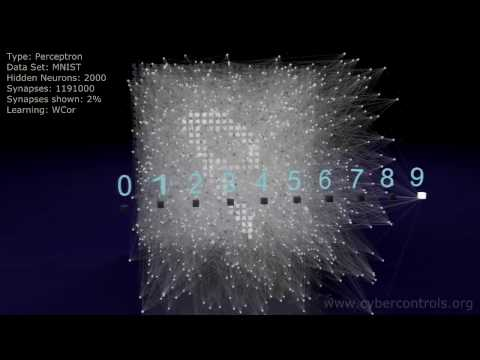

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('3JQ3hYko51Y',width="960",height="720")

# Referencias

- [Mohammed Bennamoun: Multi-Layer Perceptron and Backpropagation](https://www.slideshare.net/MohammedBennamoun/neural-networks-multilayer-perceptron-backpropagation)
- [Martin Gorner: Tensorflow Without a PHD](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#0)
- [Tensorflow Documentation: Tensorboard, Visualizing Learning](https://www.tensorflow.org/guide/summaries_and_tensorboard)
- [Easy Tensorflow: Embedding Visualization](https://www.easy-tensorflow.com/tf-tutorials/tensorboard/tb-embedding-visualization)
- [Towards Data Science: How to Improve a Neural Network with Regularization](https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3)
- [Goodfellow et. al. 2016: Deep Learning, Capítulos 7 y 8](https://www.deeplearningbook.org/)
- [Rob Robinson: Convolutional Neural Networks - Basics](https://mlnotebook.github.io/post/CNN1/)
- [Wikipedia: Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [Zhou M. : Tensorflow 19 - CNN Example Using MNIST - Neural Network Tutorials](https://github.com/MorvanZhou/tutorials/blob/master/tensorflowTUT/tf18_CNN3/full_code.py)
- [Adam W. Harley: An Interactive Node-Link Visualization of Convolutional Neural Networks](http://scs.ryerson.ca/~aharley/vis/)
- [The Mostly Complete Chart of Neural Networks, Explained](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464)
- [Neelava Sengpta: Spiking Neural Networks](https://onedrive.live.com/view.aspx?resid=E5B30858C0A33D63!24994&ithint=file%2cpptx&authkey=!ADVNDFc-pgY3C98)